<a href="https://colab.research.google.com/github/peytonCooper/stellarOccultations/blob/main/datageneration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Generation Code Stellar Occultations v1


In [ ]:
"""
<Data Generation Script for Ground Based Imaging of Satellite Occultations: Machine Learning and Analysis>

<The intent of this script is to generate data for a machine learning analysis on satellite occultations in geosynchronous orbit.>

<Capt Peyton Cooper, USSF, MIT Phantom Cohort X>

<Creation Date: 4/24/2024>

<1.0>
"""


'\n<Data Generation Script for Ground Based Imaging of Satellite Occultations: Machine Learning and Analysis>\n\n<The intent of this script is to generate data for a machine learning analysis on satellite occultations in geosynchronous orbit.>\n\n<Capt Peyton Cooper, USSF, MIT Phantom Cohort X>\n\n<Creation Date: 4/24/2024>\n\n<1.0>\n'

##  1: Necessary Imports, Permissions, Parameters

### 1.a: Install Skyfield, Astroqueary, simple libs

In [ ]:
!pip install skyfield
!pip install pandas
!pip install astroquery
from astropy.coordinates import EarthLocation, SkyCoord
import astropy.units as u
from astroquery.gaia import Gaia
import matplotlib.pyplot as plt
import math

from google.colab import drive
drive.mount('/content/drive')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 367.0/367.0 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 234.5/234.5 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 102.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 51.3 MB/s eta 0:00:00
Mounted at /content/drive


## 2: Functions

### 2.a: Calculate Az El


In [ ]:
import math

def calculate_az_el(lat, long, elevation):
    """
    Description:
    Takes in a lat long of camera site on Earth and elevation above sea level,
    generates the az el it needs to be at to point at GEO.

    Parameters:
    - lat (float): latitude of camera position on earth, in degrees
    - long (float): longitude of camera position on earth, in degrees W
    - elevation (float): elevation above sea level of camera position on earth, in meters

    Returns:
    - azimuth (float): deg, az to GEO obs
    - elevation (float): deg, el to GEO obs
    """
    # Constants
    RADIUS_EARTH = 6371  # Radius of the Earth in kilometers
    ALTITUDE_GEO = 35786  # Altitude of geosynchronous orbit in kilometers

    # Convert elevation from meters to kilometers
    elevation_km = elevation / 1000

    # Convert latitude and longitude from degrees to radians
    lat_rad = math.radians(lat)
    long_rad = math.radians(long)

    # Calculate the angle between the satellite's position and the equator
    theta = math.pi / 2 - lat_rad

    # Calculate the distance from the observer to the point directly below the satellite
    d = math.sqrt((RADIUS_EARTH + elevation_km) ** 2 * math.cos(theta) ** 2 + (RADIUS_EARTH + elevation_km) ** 2 * math.sin(theta) ** 2)

    # Calculate the elevation angle
    elevation_angle = math.degrees(math.atan((ALTITUDE_GEO - elevation_km) / d))

    # Calculate the azimuth angle
    if long >= 0:
        azimuth = math.degrees(math.atan(math.tan(long_rad) / math.sin(lat_rad)))
    else:
        azimuth = math.degrees(math.atan(math.tan(long_rad) / math.sin(lat_rad))) + 180

    # Ensure azimuth is within [0, 360) range
    azimuth = azimuth % 360

    return azimuth, elevation_angle


### 2.b: Generate Batch Time - UNUSED

In [ ]:
def generate_batch_time():
    """
    Description:
    <Brief description of what the function does>

    Parameters:
    - lat (float): latitude of camera position on earth, in degrees
    - long (float): longitude of camera position on earth, in degrees W

    Returns:
    - azimuth (float): deg, az to GEO obs
    - elevation (float): deg, el to GEO obs
    """
    return 0

###2.b.1: Generate RA and DEC

In [ ]:
from astropy.coordinates import EarthLocation, AltAz, SkyCoord
from astropy.time import Time
import astropy.units as u

def calculate_observation_parameters(latitude, longitude, altitude, epoch, fov_side_deg):
    """
    Calculate observation parameters such as altitude, azimuth, local sidereal time, and FOV coordinates.

    Parameters:
    - latitude (float): Latitude of the observer in degrees.
    - longitude (float): Longitude of the observer in degrees.
    - altitude (float): Altitude of the observer in meters.
    - epoch (datetime): Observation epoch.

    Returns:
    - altitude (astropy Quantity): Altitude of the observer.
    - azimuth (astropy Quantity): Azimuth of the observer.
    - fov_ra_deg (float): Right Ascension (RA) of the Field of View (FOV) in degrees.
    - fov_dec_deg (float): Declination (Dec) of the Field of View (FOV) in degrees.
    - fov_ra_min (float): Minimum Right Ascension (RA) of the FOV in degrees.
    - fov_ra_max (float): Maximum Right Ascension (RA) of the FOV in degrees.
    - fov_dec_min (float): Minimum Declination (Dec) of the FOV in degrees.
    - fov_dec_max (float): Maximum Declination (Dec) of the FOV in degrees.
    """

    # Convert altitude to astropy Quantity with units of meters
    altitude_meters = altitude * u.m

    # Define the EarthLocation for the observer
    observer_location = EarthLocation.from_geodetic(lon=longitude*u.deg, lat=latitude*u.deg, height=altitude_meters)

    # Convert EarthLocation to SkyCoord
    observation_coordinates = SkyCoord(observer_location.lon, observer_location.lat, frame='icrs')

    # Convert coordinates to AltAz frame
    altaz_coordinates = observation_coordinates.transform_to(AltAz(obstime=epoch, location=observer_location))

    # Extract Altitude (el) and Azimuth (az)
    altitude = altaz_coordinates.alt
    azimuth = altaz_coordinates.az

    # Convert Altitude and Azimuth to degrees
    altitude_deg = altitude.value
    azimuth_deg = azimuth.value

    # Calculate local sidereal time (LST) corresponding to the observation time
    observation_time = Time(epoch)
    lst = observation_time.sidereal_time('mean', longitude)

    # Right ascension of the zenith (closest spot in geosynchronous orbit)
    fov_ra = lst

    # Convert RA to degrees
    fov_ra_deg = (fov_ra.to(u.hourangle).value * 15)  # Convert from hours to degrees

    # Declination of the zenith (same as observer's latitude)
    fov_dec = latitude

    # Define FOV size (crop area) in degrees
    fov_width_deg = fov_side_deg  # Replace fov_side_deg with your actual FOV width
    fov_height_deg = fov_side_deg  # Replace fov_side_deg with your actual FOV height

    # Calculate FOV boundaries
    fov_ra_min = fov_ra_deg - fov_width_deg
    fov_ra_max = fov_ra_deg + fov_width_deg
    fov_dec_min = fov_dec - fov_height_deg
    fov_dec_max = fov_dec + fov_height_deg



    return altitude, azimuth, fov_ra_deg, fov_dec, fov_ra_min, fov_ra_max, fov_dec_min, fov_dec_max


###2.c: Query Star Catalog - UNUSED

In [ ]:
def query_stars():
    """
    Description:
    <Brief description of what the function does>

    Parameters:
    - lat (float): latitude of camera position on earth, in degrees
    - long (float): longitude of camera position on earth, in degrees W

    Returns:
    - azimuth (float): deg, az to GEO obs
    - elevation (float): deg, el to GEO obs
    """
    return 0

###2.d: Plot FOV Coordinates

In [ ]:
import matplotlib.pyplot as plt

def plot_fov_coordinates(fov_ra_degrees, fov_dec_degrees):
    """
    Plots the field of view (FOV) coordinates.

    Parameters:
    - fov_ra_degrees (list or array): List or array of right ascension values in degrees.
    - fov_dec_degrees (list or array): List or array of declination values in degrees.

    Returns:
    None

    Example:
    plot_fov_coordinates([10, 20, 30], [45, 55, 65])
    """
    # Plot FOV coordinates
    plt.figure(figsize=(8, 6))
    plt.plot(fov_ra_degrees, fov_dec_degrees, 'ro', label='FOV Center')
    plt.xlabel('Right Ascension (degrees)')
    plt.ylabel('Declination (degrees)')
    plt.title('Field of View (FOV) Pointing at Closest Spot to GEO, Obs from Maui')
    plt.grid(True)
    plt.legend()
    plt.show()


###2.e: Plot FOV Pixels in FOV

In [ ]:
import matplotlib.pyplot as plt

def plot_fov_pixels(crop_size_degrees):
    """
    Plots the field of view (FOV) coordinates along with camera crop size.

    Parameters:

    - crop_size_degrees (float): Size of the camera crop in degrees.

    Returns:
    Prints out a grid of pixels, just for show

    Example:
    plot_fov_with_crop([128,128])
    """
    # Generate grid of pixel coordinates within FOV
    fov_x = np.linspace(0, crop_size[0] - 1, crop_size[0])
    fov_y = np.linspace(0, crop_size[1] - 1, crop_size[1])
    fov_x_grid, fov_y_grid = np.meshgrid(fov_x, fov_y)

    # Plot FOV pixels
    plt.figure(figsize=(8, 6))
    plt.scatter(fov_x_grid, fov_y_grid, s=1, color='black')
    plt.xlabel('FOV X')
    plt.ylabel('FOV Y')
    plt.title('Field of View (FOV) Pointing at Closest Spot to GEO, Obs from Maui')
    # Invert y-axis to match typical image orientation
    plt.grid(True)
    plt.show()



###2.f: Plot Stars in FOV

In [ ]:
import matplotlib.pyplot as plt

def plot_stars_in_fov(stars_ra, stars_dec, stars_vmag, fov_ra_min, fov_ra_max, fov_dec_min, fov_dec_max):
    """
    Plot stars within a specified field of view along with the field of view box.

    Parameters:
        stars_ra (array-like): Array of Right Ascension (RA) coordinates of stars in degrees.
        stars_dec (array-like): Array of Declination (Dec) coordinates of stars in degrees.
        stars_vmag (array-like): Array of V magnitudes of stars.
        fov_ra_min (float): Minimum Right Ascension (RA) of the field of view box in degrees.
        fov_ra_max (float): Maximum Right Ascension (RA) of the field of view box in degrees.
        fov_dec_min (float): Minimum Declination (Dec) of the field of view box in degrees.
        fov_dec_max (float): Maximum Declination (Dec) of the field of view box in degrees.
    """

    # Plot the stars
    plt.figure(figsize=(10, 6))
    plt.scatter(stars_ra, stars_dec, c=stars_vmag, cmap='viridis', marker='o', alpha=0.5)

    # Plot FOV box
    plt.plot([fov_ra_min, fov_ra_max, fov_ra_max, fov_ra_min, fov_ra_min],
             [fov_dec_min, fov_dec_min, fov_dec_max, fov_dec_max, fov_dec_min],
             color='red', linestyle='--', linewidth=2, label='FOV Box')

    # Add colorbar and labels
    plt.colorbar(label='V Magnitude')
    plt.xlabel('Right Ascension (deg)')
    plt.ylabel('Declination (deg)')
    plt.title('Bright (Visible) Stars in Field of View')

    # Show plot
    plt.grid(True)
    plt.gca().invert_xaxis()  # Invert RA axis to match typical sky chart orientation
    plt.gca().invert_yaxis()  # Invert Dec axis to match typical sky chart orientation
    plt.show()

# Example usage:
# plot_stars_in_fov(stars_ra, stars_dec, stars_vmag, fov_ra_min, fov_ra_max, fov_dec_min, fov_dec_max)


###2.g: add in variable noise to query

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Function to calculate sigma_mag
def calculate_sigma_mag(SNR):
    return 1.0857 / SNR

# Function to generate a random value on the Gaussian curve given SNR
def generate_random_value(SNR):
    mean = 0
    sigma_mag = calculate_sigma_mag(SNR)
    return np.random.normal(loc=mean, scale=sigma_mag)


def add_observed_magnitude(snr, array):
    observed_magnitude = []
    for val in array:
        random_uncertainty = generate_random_value(snr)
        observed_magnitude.append(random_uncertainty + val)
    return observed_magnitude


###2.g: Generate Stars

In [ ]:
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.time import Time

def query_gaia_fov_at_epoch(fov_ra_min, fov_dec_min, fov_ra_max, fov_dec_max, epoch, vmag_cutoff=11):
    """
    Query Gaia for stars brighter than the V magnitude cutoff within a specified field of view (FOV) at a specific epoch.

    Parameters:
    - fov_ra_min (float): Minimum right ascension (RA) of the FOV in degrees.
    - fov_dec_min (float): Minimum declination (Dec) of the FOV in degrees.
    - fov_ra_max (float): Maximum right ascension (RA) of the FOV in degrees.
    - fov_dec_max (float): Maximum declination (Dec) of the FOV in degrees.
    - epoch (str): Desired epoch for the query in ISO format (e.g., '2024-04-24').
    - vmag_cutoff (float, optional): V magnitude cutoff for selecting stars. Default is 11.

    Returns:
    - astropy.table.Table: Table containing the queried data with columns:
        - 'Source ID': Gaia source ID.
        - 'RA (deg) at Epoch': Right ascension (RA) in degrees at the specified epoch.
        - 'Dec (deg) at Epoch': Declination (Dec) in degrees at the specified epoch.
        - 'V Magnitude': V magnitude of the star.

    Example:
    >>> query_gaia_fov_at_epoch(10, -10, 20, 10, '2024-04-24')
    """

    # Query Gaia for stars brighter than the V magnitude cutoff in the FOV
    query_str_bright = """
    SELECT source_id, ra, dec, phot_g_mean_mag
    FROM gaiadr2.gaia_source
    WHERE CONTAINS(POINT('ICRS', ra, dec), POLYGON('ICRS', {}, {}, {}, {}, {}, {}, {}, {})) = 1
    AND phot_g_mean_mag < {};
    """.format(
    fov_ra_min, fov_dec_min,
    fov_ra_max, fov_dec_min,
    fov_ra_max, fov_dec_max,
    fov_ra_min, fov_dec_max,
    vmag_cutoff
    )

    job_bright = Gaia.launch_job(query_str_bright)
    results_bright = job_bright.get_results()

    from astropy.table import Table

    # Create an empty table
    table_data = Table()

    # Add columns to the table
    table_data['Source ID'] = results_bright['source_id']
    table_data['RA (deg)'] = results_bright['ra']
    table_data['Dec (deg)'] = results_bright['dec']
    table_data['V Magnitude'] = results_bright['phot_g_mean_mag']

    return table_data


###2.h: Print the table

In [ ]:
from tabulate import tabulate

def print_2d_array(array, headers=None):
    print(tabulate(array, headers=headers, tablefmt="grid"))


### 2.i: Calculate Photon Count

In [ ]:
"""
    Plot stars within a specified field of view along with the field of view box.

    Parameters:
        stars_ra (array-like): Array of Right Ascension (RA) coordinates of stars in degrees.
        stars_dec (array-like): Array of Declination (Dec) coordinates of stars in degrees.
        stars_vmag (array-like): Array of V magnitudes of stars.
        fov_ra_min (float): Minimum Right Ascension (RA) of the field of view box in degrees.
        fov_ra_max (float): Maximum Right Ascension (RA) of the field of view box in degrees.
        fov_dec_min (float): Minimum Declination (Dec) of the field of view box in degrees.
        fov_dec_max (float): Maximum Declination (Dec) of the field of view box in degrees.
    """

def calculate_photons_detected(magnitude, telescope_diameter, filter_bandpass, efficiency, final_bright_stars):
    # Constants
    #print(magnitude)
    F0 = 3.61e-11 # Flux of a V=0 star in W m^-2 nm^-1 (http://www.vikdhillon.staff.shef.ac.uk/teaching/phy217/instruments/phy217_inst_photsys.html#table1) spectral flux
    wavelength = 550 * 1e-9 # Effective wavelength of V band in nm
    h = 6.626e-34  # Planck's constant in J s
    c = 3e8  # Speed of light in m/s

    # Calculate flux from the star
    F1 = F0 * (10 ** ((magnitude - 0) / -2.5))
    #print("F1: ", F1)
    # Calculate number of photons per second per square meter
    N1 = F1 * wavelength / (h * c)
    #print("N1: ", N1)
    # Calculate total number of photons detected per second
    photons_detected_per_second = N1 * np.pi * (telescope_diameter / 2)**2 * filter_bandpass * efficiency
    #print(photons_detected_per_second)
    return photons_detected_per_second

### 2.j: Calculate SKy Photons

In [ ]:
"""
    Calculate the number of sky background photons detected per second in an extraction aperture. NOTE* These constants come mostly from the camera I am using, found on fact sheet for Andor EMECC

    Parameters:
    ----------
    sky_brightness_mag_per_arcsec2 : float
        Sky brightness in magnitudes per square arcsecond.
    telescope_diameter_m : float
        Diameter of the telescope aperture in meters.
    filter_bandpass_nm : float
        Width of the filter bandpass in nanometers.
    system_efficiency : float
        Total system efficiency (includes optics, detector QE, etc.), from 0 to 1.
    aperture_radius_arcsec : float
        Radius of the circular photometric aperture, in arcseconds.

    Returns:
    -------
    photons_detected_per_second : float
        Estimated number of sky background photons detected per second within the aperture.
    """
def calculate_sky_photons_per_second(sky_brightness, telescope_diameter, filter_bandpass, efficiency, aperture_radius):
    # Convert sky brightness from magnitudes per square arcsecond to W m^-2 nm^-1 arcsecond^-2
    F0 = 3.61e-11 # Flux of a V=0 star in W m^-2 nm^-1 (http://www.vikdhillon.staff.shef.ac.uk/teaching/phy217/instruments/phy217_inst_photsys.html#table1)
    wavelength = 550  # Effective wavelength of V band in nm
    h = 6.626e-34  # Planck's constant in J s
    c = 3e8  # Speed of light in m/s
    F1 = F0 * (10 ** ((sky_brightness - 0) / -2.5))
    #print("F1: ", F1)
    # Calculate number of photons s^-1 m^-2 nm^-1 arcsecond^-2
    N1 = F1 * (550e-9) / (h * c)  # Number of photons s^-1 m^-2 nm^-1 arcsecond^-2
    #print("N1 : ", N1)
    # Calculate total number of photons per second from the sky detected in the extraction aperture
    photons_per_second = N1 * (math.pi * (aperture_radius**2)) * (math.pi*(telescope_diameter / 2)**2) * filter_bandpass * efficiency

    return photons_per_second


###2.k: Filter by Star and Print, plot star observation


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress

def plot_star_observation(final_bright_stars, star_id, start_epoch):
    # Filter the final_bright_stars table based on the target_source_id
    target_stars = final_bright_stars[final_bright_stars['Source ID'] == star_id]

    # Extract epoch, observed magnitude, and count data for the target source ID
    epochs_target = target_stars['Epoch']
    observed_magnitudes_target = target_stars['Observed Magnitude']
    counts_target = target_stars['count']  # Assuming 'count' is the variable name
    truth_value = target_stars['truth']

    # Convert epoch to milliseconds
    start_time_ms = (start_epoch - start_epoch).total_seconds() * 1000  # Convert start_epoch to milliseconds
    epochs_ms = [(epoch - start_epoch).total_seconds() * 1000 for epoch in epochs_target]

    # Calculate mean and standard deviation for observed magnitudes and counts
    mean_observed_mag = np.mean(observed_magnitudes_target)
    std_observed_mag = np.std(observed_magnitudes_target)
    mean_count = np.mean(counts_target)
    std_count = np.std(counts_target)

    # Plot observed magnitude vs time for the target source ID
    plt.figure(figsize=(12, 6))

    # Subplot for observed magnitude
    plt.subplot(1, 2, 1)

    # Plot all data points
    plt.plot(epochs_ms, observed_magnitudes_target, marker='o', linestyle='', color='blue', alpha=0.5, label='Observed Magnitude (No Occultation)')

    # Plot data points with truth value == 1 in red
    # plt.plot([epoch for truth, epoch in zip(truth_value, epochs_ms) if truth == 1],
    #          [count for truth, count in zip(truth_value, observed_magnitudes_target) if truth == 1],
    #          marker='o', linestyle='', color='red', alpha=0.5, label='Occultation Obs')

    # Plot mean, standard deviation, and line of best fit
    plt.axhline(y=mean_observed_mag, color='red', linestyle='--', label='Gaia Vmag Baseline for Star ID')
    plt.axhline(y=mean_observed_mag + std_observed_mag, color='green', linestyle='--', label='+1 Stdev')
    plt.axhline(y=mean_observed_mag - std_observed_mag, color='green', linestyle='--', label='-1 Stdev')
    slope_obs, intercept_obs, _, _, _ = linregress(epochs_ms, observed_magnitudes_target)
    #plt.plot(epochs_ms, slope_obs * np.array(epochs_ms) + intercept_obs, color='black', label='Line of Best Fit')

    plt.xlabel('Epoch (ms)')
    plt.ylabel('Observed Magnitude (Noise Injected)')
    plt.title('Noisy Observed Magnitude vs Time for Star ID: {}'.format(star_id))
    plt.legend()
    plt.grid(True)

    # Subplot for count
    plt.subplot(1, 2, 2)

    # Plot all data points
    plt.plot(epochs_ms, counts_target, marker='o', linestyle='', color='green', alpha=0.5, label='Count')

    # Plot data points with truth value == 1 in red
    #plt.plot([epoch for truth, epoch in zip(truth_value, epochs_ms) if truth == 1],
             #[count for truth, count in zip(truth_value, counts_target) if truth == 1],
            # marker='o', linestyle='', color='red', alpha=0.5, label='Occultation Obs')

    # Plot mean, standard deviation, and line of best fit
    plt.axhline(y=mean_count, color='red', linestyle='--', label='Mean Count')
    plt.axhline(y=mean_count + std_count, color='blue', linestyle='--', label='+1 Stdev')
    plt.axhline(y=mean_count - std_count, color='blue', linestyle='--', label='-1 Stdev')
    slope_count, intercept_count, _, _, _ = linregress(epochs_ms, counts_target)
    #plt.plot(epochs_ms, slope_count * np.array(epochs_ms) + intercept_count, color='black', label='Line of Best Fit')

    plt.xlabel('Epoch (ms)')
    plt.ylabel('Photon Count')
    plt.title('Photon Count vs Time for Star ID: {}'.format(star_id))
    plt.legend()
    plt.grid(True)

    # Adjust layout
    plt.tight_layout()

    # Show plot
    plt.show()

    # Filter the final_bright_stars table based on the target_source_id
    target_stars = final_bright_stars[final_bright_stars['Source ID'] == star_id]

    # Print the attributes of the target stars
    print("Attributes of stars with Source ID:", star_id)
    print(target_stars)




### 2.l: Add noise to count




In [ ]:
import numpy as np
import matplotlib.pyplot as plt


# Function to generate a random value on the Gaussian curve given SNR
def generate_random_value_noise(noise):
    mean = 0
    sigma_mag = noise
    return np.random.normal(loc=mean, scale=sigma_mag)


def add_noise_to_count(noise):
  random_uncertainty = generate_random_value_noise(noise)
  return random_uncertainty


###2.m: calculate satellite params
velocity, crossing time, and angle of rso

In [ ]:
def calculate_satellite_params(r,rso):
  G=6.674e-11 #Nm2/kg2
  M=5.976e24 #kg
  rearth=6378e3 #m
  #tangential velocity overhead
  velocity=math.sqrt((G*M)/r) #m/s
  #print("velocity: ", velocity, "m/s")
  #print("velocity: ", velocity/1000, "km/s")

  #satellite occultation disk angular diameter, theta rso
  thetaRSO=(rso/(r-rearth)) #GEO distance from observer
  #print("ThetaRSO: ", thetaRSO, "rads")  #This is the instantaneous fractional area blocked by the satellite
  thetaRSO=thetaRSO*206264.8062470
  #print("ThetaRSO: ", thetaRSO, "arcsec")

  #crossing time
  ts=rso/velocity
  #print("crossing time: ", ts , "seconds")
  #print("crossing time: ", ts*1000 , "mseconds")
  return(velocity,thetaRSO,ts)


###2.n: Save data to Excel file named epoch

In [ ]:
from datetime import datetime
import pandas as pd

def save_data_to_excel(table_data, start_epoch, file_path_template):
    # Convert astropy table to pandas DataFrame
    df = table_data.to_pandas()

    # Convert start_epoch to a string
    start_epoch_str = start_epoch.strftime("%Y-%m-%d_%H-%M-%S")

    # Generate the final file path by inserting start_epoch string into the template
    excel_file_path = file_path_template.format(start_epoch_str)

    # Write DataFrame to Excel
    df.to_excel(excel_file_path, index=False)  # Set index=False to exclude row numbers in Excel




###2.o: Plot Photon Histogram Counts

In [ ]:
def plot_counts_histogram(final_bright_stars, star_id):
    # Filter the final_bright_stars table based on the target_source_id
    target_stars = final_bright_stars[final_bright_stars['Source ID'] == star_id]

    # Extract counts data and truth values for the target source ID
    counts_target = target_stars['count']
    truth_value = target_stars['truth']
    vmag_true = target_stars['V Magnitude']
    print("vmag true:", vmag_true)

    mean_count = calculate_photons_detected(vmag_true, aperture_radius, filter_bandpass, efficiency, star_id)
    mean_count = mean_count[0] * 0.005
    print("mean count", mean_count)
    std_count = np.std(counts_target)

    # Separate the counts for occultation and non-occultation
    counts_occultation = counts_target[truth_value == 1]
    counts_non_occultation = counts_target[truth_value == 0]

    # Plot histogram of photon count
    plt.figure(figsize=(10, 6))

    # Plot non-occultation counts
    plt.hist(counts_non_occultation, bins=30, color='blue', alpha=0.5, label='Photon Count (Non-Occultation)')

    # Overlay occultation counts
    #plt.hist(counts_occultation, bins=30, color='red', alpha=0.9, label='Photon Count (Occultation)')

    # Plot mean and standard deviations
    plt.axvline(mean_count, color='orange', linestyle='--', label='Photon Count of Gaia Baseline Entry')
    plt.axvline(mean_count + std_count, color='green', linestyle='--', label='+1 Stdev')
    plt.axvline(mean_count - std_count, color='green', linestyle='--', label='-1 Stdev')
    plt.axvline(mean_count + 2 * std_count, color='purple', linestyle='--', label='+2 Stdev')
    plt.axvline(mean_count - 2 * std_count, color='purple', linestyle='--', label='-2 Stdev')

    plt.xlabel('Photon Count')
    plt.ylabel('Frequency')
    plt.title('Histogram of Noise Injected Photon Counts for Star ID: {}'.format(star_id))
    plt.legend()
    plt.grid(True)

    # Show plot
    plt.show()

###2.p: Plot Histogram Observed Magnitude

In [ ]:

def plot_obs_histogram(final_bright_stars, star_id):
    # Filter the final_bright_stars table based on the target_source_id
    target_stars = final_bright_stars[final_bright_stars['Source ID'] == star_id]

    # Extract counts data and truth values for the target source ID
    obs_target = target_stars['Observed Magnitude']
    truth_value = target_stars['truth']
    vmag_true = target_stars['V Magnitude']
    print("vmag true:", vmag_true)

    mean_count = vmag_true[0]
    print("mean count", mean_count)
    std_count = np.std(obs_target)

    # Separate the counts for occultation and non-occultation
    counts_occultation = obs_target[truth_value == 1]
    counts_non_occultation = obs_target[truth_value == 0]

    # Plot histogram of photon count
    plt.figure(figsize=(10, 6))

    # Plot non-occultation counts
    plt.hist(counts_non_occultation, bins=30, color='blue', alpha=0.7, label='Observed Magnitude (Non-Occultation)')

    # Overlay occultation counts
    plt.hist(counts_occultation, bins=30, color='red', alpha=0.7, label='Observed Magnitude (Occultation)')

    # Plot mean and standard deviations
    plt.axvline(mean_count, color='orange', linestyle='--', label='Count of Gaia Visual Magnitude')
    plt.axvline(mean_count + std_count, color='green', linestyle='--', label='+1 Stdev')
    plt.axvline(mean_count - std_count, color='green', linestyle='--', label='-1 Stdev')
    plt.axvline(mean_count + 2 * std_count, color='purple', linestyle='--', label='+2 Stdev')
    plt.axvline(mean_count - 2 * std_count, color='purple', linestyle='--', label='-2 Stdev')
    plt.xlim(left=min(obs_target), right=max(obs_target))

    plt.xlabel('Observed Noisy Vmag')
    plt.ylabel('Frequency')
    plt.title('Histogram of Noise Injected Observed Vmags for Star ID: {}'.format(star_id))
    plt.legend()
    plt.grid(True)


    # Show plot
    plt.show()

#3: Parameter Definitions and Main

### 3.a: Camera Parameter Setup
This will define all parameters for the example camera in question: the Andor iXon Ultra 888 EMCCD. Parameters defined here given by USAF POC.


In [ ]:

# @title
from datetime import datetime, timedelta
from astropy.coordinates import EarthLocation, AltAz
from astropy.time import Time
import astropy.units as u
import numpy as np

# Observer location parameters
latitude = 20.7   # Latitude in degrees
longitude = -156.3   # Longitude in degrees W GMT
site_altitude = 3058  # Altitude in meters
azimuth,elevation=calculate_az_el(latitude,longitude, site_altitude)

# Observation parameters
start_epoch = datetime(2022, 3, 1, 10, 0, 0)  # Start time (February 19, 2024, at midnight local)
step_time = 10  # Time increment for simulation in seconds
duration = 8 * 3600  # Total observation time (8 hours)

# Other parameters
fov_side_deg = 0.5  # Field of view (FOV) side in degrees
fov_side_arcsec = 4.3  # Instantaneous Field of View (IFOV) in arcseconds
max_occultation_threshold = 0.10  # Threshold for detecting occultation (10% reduction in photon flux)
fov_at_geo_width=23.78*1000 #km
fov_at_geo_height=23.78*1000 #km

# Camera parameters
frame_rate = 0.0056  # Frame rate in frames per second (5.6 ms framerate)
crop_size = (128, 128)  # Crop size of the camera
binning = 4  # Binning factor
pixels_per_second_at_geo=15/fov_side_arcsec #geodeg/fov_side_arcsec
print(f"""
# Define observer location parameters
latitude = '{latitude}'   # Latitude in degrees
longitude = '{longitude}'  # Longitude in degrees E GMT
site_altitude = {site_altitude}  # Altitude in meters
azimuth = {azimuth} #deg: az to geo obs
elevation = {elevation} #deg: elevation of pointing from spot to geo obs

# Observation parameters
start epoch = {start_epoch}  # Start time (February 19, 2024, at midnight local)
step_time = {step_time}  # Time increment for simulation in seconds
duration = {duration}  # Total observation time (8 hours)

# Other parameters
fov_side_deg = {fov_side_deg}  # Field of view (FOV) side in degrees
fov_side_arcsec = {fov_side_arcsec}  # Instantaneous Field of View (IFOV) in arcseconds
max_occultation_threshold = {max_occultation_threshold}  # Threshold for detecting occultation (10% reduction in photon flux)
pixels_per_second_at_geo={pixels_per_second_at_geo} #pixels/sec stars are drifting through

# Camera parameters
frame_rate = {frame_rate}  # Frame rate in frames per second (5.6 ms framerate)
crop_size = {crop_size}  # Crop size of the camera
binning = {binning}  # Binning factor
""")

# Call the function to calculate observation parameters
altitude, azimuth, fov_ra, fov_dec, fov_ra_min, fov_ra_max, fov_dec_min, fov_dec_max = calculate_observation_parameters(latitude, longitude, site_altitude, start_epoch, fov_side_deg)

# Print out the results
print("Altitude:", altitude)
print("Azimuth:", azimuth)
print("FOV Right Ascension (RA):", fov_ra)
print("FOV Declination (Dec):", fov_dec)


# Define observer location parameters
latitude = '20.7'   # Latitude in degrees
longitude = '-156.3'  # Longitude in degrees E GMT
site_altitude = 3058  # Altitude in meters
azimuth = 231.15765571070443 #deg: az to geo obs
elevation = 79.8997746049597 #deg: elevation of pointing from spot to geo obs

# Observation parameters
start epoch = 2022-03-01 10:00:00  # Start time (February 19, 2024, at midnight local)
step_time = 10  # Time increment for simulation in seconds
duration = 28800  # Total observation time (8 hours)

# Other parameters
fov_side_deg = 0.5  # Field of view (FOV) side in degrees
fov_side_arcsec = 4.3  # Instantaneous Field of View (IFOV) in arcseconds
max_occultation_threshold = 0.1  # Threshold for detecting occultation (10% reduction in photon flux)
pixels_per_second_at_geo=3.488372093023256 #pixels/sec stars are drifting through

# Camera parameters
frame_rate = 0.0056  # Frame rate in frames per second (5.6 ms framerate)
crop_size = (128, 128)  # Crop size of the

This defines the FOV center Coords in RA and DEC, and the FOV boundaries

In [ ]:
print(altitude)

42d24m48.74401173s


###3.b: Visualize Baseline FOV-optional

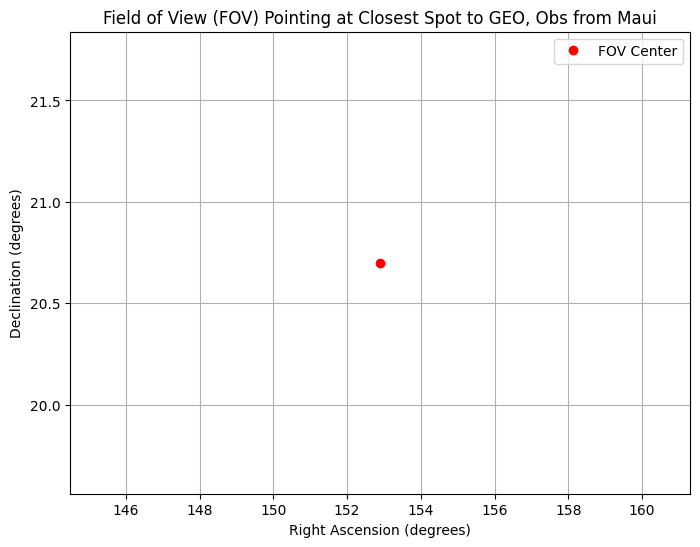

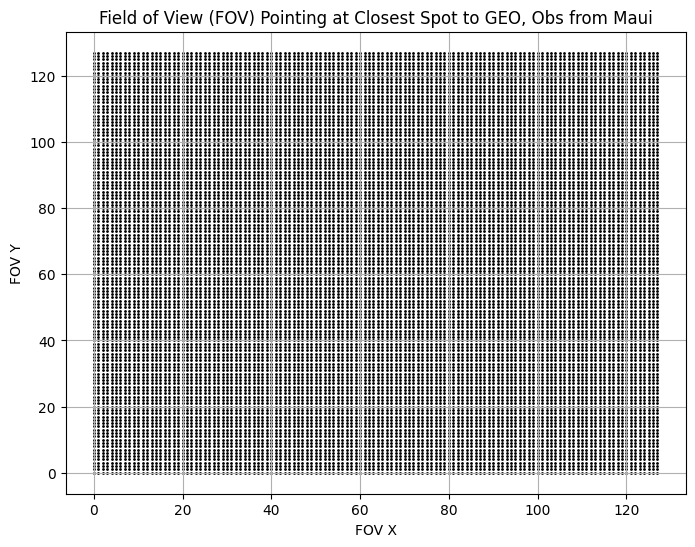

In [ ]:
plot_fov_coordinates(fov_ra,fov_dec)
plot_fov_pixels(crop_size)

#4: Query Star Catalog

<Table length=11>
    Source ID           RA (deg)          Dec (deg)      V Magnitude
                          deg                deg             mag    
      int64             float64            float64         float32  
------------------ ------------------ ------------------ -----------
625426987250746112   153.154648243823 20.482527322655788    9.223762
625421077375748992 153.09277656796255 20.338230289278833   10.797385
625395758543540992   153.031089136432  20.21633639092781    9.782532
625392902390288896 152.75698982086632 20.206054953373865   10.408919
628447487426672512 152.78623500754063  20.69554120897314   6.5306683
628407900712258432 152.69735279797308  20.45869761391244   10.979878
628457378735500032 153.08729663079663 20.905031219118985     9.87105
628401028764960512 152.53695464113622  20.36351680151607    10.50192
628505246146831360 152.59436552804846 20.945603833010885   7.3214993
628410791226127360   152.395156823551  20.30237197141823    9.608063
6285100178546773

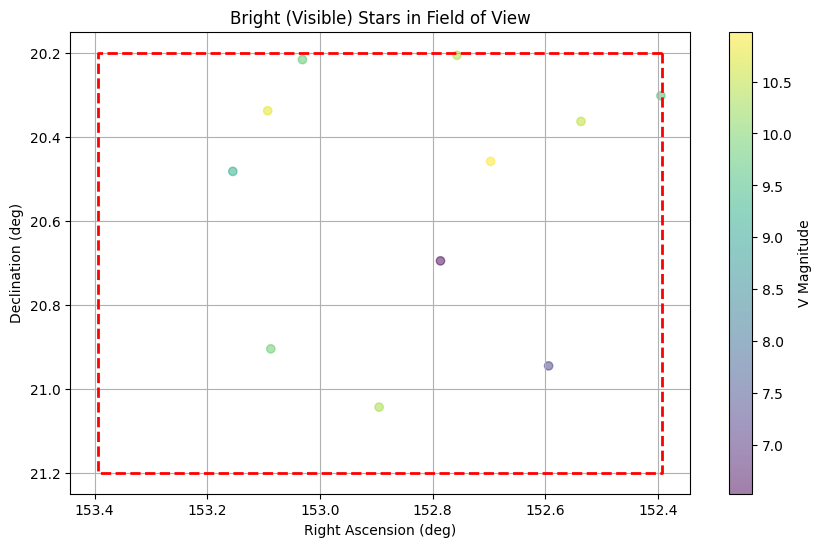

In [ ]:
from pprint import pprint

# Call the function and store the returned table data
bright_stars = query_gaia_fov_at_epoch(fov_ra_min, fov_dec_min, fov_ra_max, fov_dec_max, start_epoch, vmag_cutoff=11)

# Print the entire table nicely
pprint(bright_stars)

plot_stars_in_fov(bright_stars['RA (deg)'], bright_stars['Dec (deg)'], bright_stars['V Magnitude'], fov_ra_min, fov_ra_max, fov_dec_min, fov_dec_max)


# 5: Looper
Lets loop through time

*   step: I define this as integration time steps up to a threshold ie: feb 19 2024 10:00:00:05, feb 19 2024 10:00:00:10 etc up to feb 19 2024 10:00:10:00, our threshold is 10s.

*   batch: new random date, contains steps ie: feb 19 2024, mar 20 1990, etc

*   bright_stars array: star id, ra, dec, vmag

*   step_array: star id, ra, dec, vmag, time

*   finalstep_array: star id, ra, dec, count, time, truth





In [ ]:
from datetime import datetime, timedelta
import time
from astropy.table import Table, vstack  # Import Table class and vstack function from astropy.table module
from tqdm import tqdm

# Record the start time
start_time = time.time()

epoch_increment = timedelta(milliseconds=5.6)  # Increment epoch by 5 milliseconds this number was calculated
counter = 0
bright_stars_list = []  # List to store bright stars data with epoch time
snr=9.5
# Loop through the epochs and calculate observation parameters

# Initialize current_epoch and other necessary variables before this block
current_epoch = start_epoch
total_epochs = (timedelta(seconds=0.5) // epoch_increment) + 1
print(total_epochs)
# Create a tqdm progress bar
with tqdm(total=total_epochs) as pbar:
    while current_epoch <= start_epoch + timedelta(seconds=0.5):  # Loop for x seconds THIS IS THE TIME PARAM (timedelta(seconds=how long you want to run for))
        # Call the function to calculate observation parameters for the current epoch
        altitude, azimuth, fov_ra, fov_dec, fov_ra_min, fov_ra_max, fov_dec_min, fov_dec_max = calculate_observation_parameters(
            latitude, longitude, site_altitude, current_epoch, fov_side_deg)

        # Query the data
        # Call the function and store the returned table data
        bright_stars = query_gaia_fov_at_epoch(fov_ra_min, fov_dec_min, fov_ra_max, fov_dec_max, start_epoch, vmag_cutoff=11)

        # Append epoch time to each entry in bright_stars
        bright_stars['Epoch'] = current_epoch

        # Add observed magnitude to bright_stars
        bright_stars['Observed Magnitude'] = add_observed_magnitude(snr, bright_stars['V Magnitude'])

        # Append bright_stars to the list
        bright_stars_list.append(bright_stars)

        # Increment the epoch by 5 milliseconds for the next iteration
        current_epoch += epoch_increment
        counter += 1

        # Update the progress bar
        pbar.update(1)

print("Code ran:", counter, "times.")
print("start epoch:", start_epoch)
print("end epoch:", current_epoch)


# Concatenate the tables in bright_stars_list
final_bright_stars = vstack(bright_stars_list)


# Record the end time
end_time = time.time()

# Calculate the runtime
runtime = end_time - start_time

# Print the first few and last few items in final_bright_stars
print("Length of final_bright_stars:", len(final_bright_stars))
print("First few items in final_bright_stars:")
print(final_bright_stars[:5])  # Print the first 5 rows
print("\nLast few items in final_bright_stars:")
print(final_bright_stars[-5:])  # Print the last 5 rows

# Print the runtime
print("Runtime:", runtime, "seconds")


90


 27%|██▋       | 24/90 [35:17<1:36:35, 87.82s/it]

In [ ]:
# Define the source ID you want to search for
target_source_id = 628852004626257152     # Replace this with the desired source ID

# Filter the final_bright_stars table based on the target_source_id
target_stars = final_bright_stars[final_bright_stars['Source ID'] == target_source_id]

# Print the attributes of the target stars
print("Attributes of stars with Source ID:", target_source_id)
print(target_stars)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define the source ID you want to plot
target_source_id = 625571989641269120    # Replace this with the desired source ID

# Filter the final_bright_stars table based on the target_source_id
target_stars = final_bright_stars[final_bright_stars['Source ID'] == target_source_id]

# Extract epoch and observed magnitude data for the target source ID
epochs_target = target_stars['Epoch']
observed_magnitudes_target = target_stars['Observed Magnitude']

# Convert epoch to milliseconds
start_time_ms = (start_epoch - start_epoch).total_seconds() * 1000  # Convert start_epoch to milliseconds
epochs_ms = [(epoch - start_epoch).total_seconds() * 1000 for epoch in epochs_target]

# Plot observed magnitude vs time for the target source ID
plt.figure(figsize=(10, 6))
plt.plot(epochs_ms, observed_magnitudes_target, marker='o', linestyle='', color='blue', alpha=0.5, label='Observed Magnitude')

# Calculate mean observed magnitude for the target source ID
mean_observed_magnitude_target = np.mean(observed_magnitudes_target)

# Plot mean as a horizontal line for the target source ID
plt.axhline(y=mean_observed_magnitude_target, color='red', linestyle='--', label='Mean Observed Magnitude')

# Add labels and title
plt.xlabel('Epoch (ms)')
plt.ylabel('Observed Magnitude (Vmag)')
plt.title('Observed Magnitude vs Time for Star ID: {}'.format(target_source_id))
plt.legend()

# Show plot
plt.grid(True)
plt.show()


### 5.b: Loop through and calculate count#

In [ ]:
import numpy as np
# Add a new column called "truth" filled with zeros, nominal
final_bright_stars['count'] = np.zeros(len(final_bright_stars), dtype=float)


telescope_diameter = 1  # Telescope diameter in meters
filter_bandpass = 86  # Bandpass of the filter CHANGE
efficiency = 0.9  # Overall telescope/instrument/filter/detector efficiency
aperture_radius=1
sky_brightness=19

# Iterate through final_bright_stars and calculate photons detected for each star

for index in range(len(final_bright_stars)):
    magnitude = final_bright_stars['Observed Magnitude'][index]
    photons_detected = calculate_photons_detected(magnitude, telescope_diameter, filter_bandpass, efficiency, final_bright_stars)
    final_bright_stars['count'][index] = photons_detected

#Print final_bright_stars with the 'count' column added
#print(final_bright_stars)

for index in range(len(final_bright_stars)):
    count_value = float(final_bright_stars['count'][index])
    count_value=count_value*0.005
    final_bright_stars['count'][index] = count_value



final_bright_stars_nominal=final_bright_stars
print(final_bright_stars_nominal)

print(final_bright_stars)

In [ ]:
import math
aperture_radius = 1  # Aperture radius in radians (converted from arcseconds)
sky_brightness = 19  # Sky brightness in magnitudes per square arcsecon"d
photons_per_second = calculate_sky_photons_per_second(sky_brightness, telescope_diameter, filter_bandpass, efficiency, aperture_radius)
print("Number of photons per second from the sky recorded in the aperture:", photons_per_second*0.005)


###Count Comparison Noise


Photon count from the star without noise:

PhotonCount_Star = PhotonsPerSecond_Star * ExposureTime


Calculate the photon count from the noise:

Convert electronic noise and sky background noise from electrons to photons using the quantum efficiency:


PhotonsFromElectronicNoise = ElectronicNoise * QuantumEfficiency


PhotonsFromSkyBackgroundNoise = SkyBackgroundNoise * QuantumEfficiency


TotalPhotonCount_Noise = PhotonsFromElectronicNoise + PhotonsFromSkyBackgroundNoise

In [ ]:
for index in range(len(final_bright_stars_nominal)):
    count_value = float(final_bright_stars_nominal['count'][index])
    count_value_electronic_noise=100*.9 #90% efficient?
    photons_per_second = calculate_sky_photons_per_second(sky_brightness, telescope_diameter, filter_bandpass, efficiency, aperture_radius)
    count_value_sky=photons_per_second*frame_rate
    noise=count_value_electronic_noise+count_value_sky
    final_bright_stars_nominal['count'][index] = count_value+add_noise_to_count(noise)

print(final_bright_stars_nominal)

Compare the two photon counts:
Compare PhotonCount_Star and TotalPhotonCount_Noise to see the impact of noise on your measurement.

###  5.c: Add Truth to entry
0: indicates nominal noise
1: indicates occultation event

In [ ]:
# Add a new column called "truth" filled with zeros, nominal
final_bright_stars_nominal['truth'] = np.zeros(len(final_bright_stars), dtype=int)

# Verify the addition of the new column

headers = list(final_bright_stars_nominal[0].keys())
print(headers)
print_2d_array(final_bright_stars_nominal, headers)


In [ ]:
plot_star_observation(final_bright_stars_nominal, 628457378735500032, start_epoch)


#6: Occultation Injection

Find the projected solid angle of the satellite on telescope. This will return how much light from an incoming star a satellite is blocking. Scale % blocked to count.


In [ ]:
# import math

# geo_distance_from_loc=(35796/math.tan(latitude * math.pi / 180))*1000
# print(geo_distance_from_loc, "m from GEO")

# thetaRSO=(rso/geo_distance_from_loc) #GEO distance from observer
# thetaRSO=math.atan(thetaRSO)
# print("ThetaRSO: ", thetaRSO, "rads")  #This is the instantaneous fractional area blocked by the satellite

# a_satellite=math.pi*(rso/2)**2
# print("a: ", a_satellite)

# solid_angle=a_satellite/geo_distance_from_loc**2
# print("solid angle: ",solid_angle)

### How large does RSO need to be to notice dip- Side calculation

In [ ]:
#the tangental velocity of a satellte passing overhead, ignoring earth rotation

r=36000000 #m
rso=5 #this is diameter of rso

#period=2*math.pi*math.sqrt((r**3)/(G*M))
#print(period/3600)

# Satellite diameters
satellite_diameters = [0.5, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 50, 65]
crossing_times_ms = []

# Loop through satellite diameters and calculate crossing times
for rso_loop in satellite_diameters:
    velocity, thetaRSO, ts = calculate_satellite_params(r, rso_loop)
    ts_ms = ts * 1000  # Convert to milliseconds
    crossing_times_ms.append(ts_ms)
    # Print the satellite diameter and crossing time
    print(f'Satellite Diameter: {rso_loop} m, Crossing Time: {ts_ms:.6f} ms')



# Find the index of the crossing time closest to 5.6 milliseconds
index_5ms = min(range(len(crossing_times_ms)), key=lambda i: abs(crossing_times_ms[i] - 5.6))

# Retrieve the corresponding satellite diameter
x_point = satellite_diameters[index_5ms]

# Plot the graph
plt.plot(satellite_diameters, crossing_times_ms, marker='o')
plt.axhline(y=5.6, color='r', linestyle='--')  # Add a red dashed line at y=5.6
plt.axvline(x=x_point, color='g', linestyle='--')  # Add a green dashed line at x=satellite diameter where crossing time = 5.6ms
plt.title('Crossing Time vs. Satellite Diameter')
plt.xlabel('Satellite Diameter (m)')
plt.ylabel('Crossing Time (ms)')
plt.grid(True)
plt.show()










###Calculate the projection specifics

In [ ]:
r=36000000
rso=5
velocity,thetaRSO,ts=calculate_satellite_params(r,rso)
print("Satellite velocity(velocity): ", velocity, "m/s")
print("Satellite angle projected from observer(thetaRSO): ", thetaRSO, "arcsec")

print("Satellite crossing time(ts): ", ts, "s")

def calculate_projection_area(telescope_diameter, angle_arcsec):
    """
    Calculate the area of the projection given the diameter of the telescope and the angle in square arcseconds.

    Parameters:
        telescope_diameter (float): Diameter of the telescope (in meters).
        angle_arcsec (float): Angle of the projection (in square arcseconds).

    Returns:
        float: Area of the projection (in square meters).
    """
    # Convert square arcseconds to square degrees
    angle_degrees = angle_arcsec / (3600 ** 2)

    # Calculate the area of the projection in square meters
    projection_area = ((telescope_diameter / 2) ** 2) * (angle_degrees * (2 * math.pi))

    return projection_area


def calculate_percentage_used(telescope_diameter, projection_diameter):
    """
    Calculate the percentage of the telescope's diameter used by the projection.

    Parameters:
        telescope_diameter (float): Diameter of the telescope (in meters).
        projection_diameter (float): Diameter of the projection (in meters).

    Returns:
        float: Percentage of the telescope's diameter used by the projection.
    """
    percentage_used = (projection_diameter / telescope_diameter) * 100
    return percentage_used




projection_area = calculate_projection_area(telescope_diameter, thetaRSO)
print("Projection Diameter(projection_diameter):", projection_area, "meters^2")
percentage_used = calculate_percentage_used(telescope_diameter, projection_area)
print("Percentage of telescope used by projection:", percentage_used, "%")

###Calculate the count reduction caused by the occultation
effect is how many frames we see changed based off of our crossing time and frame rate

fraction decrease in light is 1/how many frames we see it.

In [ ]:
#this is only for int times longer than crossing time
effect=frame_rate/ts #ratio of integration time to crossing time, GROOT
print("effect: ", effect)
print(ts)

#else, shorter only 1 instance of occ.

#GROOT 4.1 first paragraph last sentence
fraction_decrease_light=1/effect
print("decrease_in_light: ", fraction_decrease_light)
percentage_decrease_light=fraction_decrease_light*100
print("decrease in light percentage: ", percentage_decrease_light)

###Insert Occultation into data set
occ rate is what percentage of time do we expect to see an occ, for purposes of training i set it at 10% just for now.

ts is #crossing time ts=rso(m)/velocity(tangential velocity as seen overhead m/s)


In [ ]:
import random
occ_rate=10 #example  for data generation purposes, 10% of the time, I will see a decrease in light from occultation
ts_ms=ts*1000
print(ts_ms)
frame_count=(frame_rate*1000)/ts_ms #how many frames can i fit in the integration time
print("frame_count: ", frame_count)
frame_count=round(frame_count)
print("rounded_frame_count: ", frame_count)

##########################################################################
#METHOD 1: Use total time to inject
#calculate total time, take occ rate % of that
#loop through, select random star and inject occultation

def calculate_total_time_occ(occ_rate,ts_ms):
  total_times_occ=(occ_rate/100)*counter
  return total_times_occ

def select_random_star_one(unique_source_ids):
  selected_stars = random.sample(list(unique_source_ids),1)
  return selected_stars

def decrease_light_one(selected_stars, frame_count, decrease_percentage, final_bright_stars):
    for star_id in selected_stars:
        # Filter rows for the current star ID
        star_rows = [star for star in final_bright_stars if star['Source ID'] == star_id]
        # Select a random start index
        start_index = random.randint(0, len(star_rows) - frame_count)
        # Iterate through the selected rows and decrease count
        for i in range(start_index, start_index + frame_count):
            row = star_rows[i]
            row['count'] -= int(row['count'] * decrease_percentage / 100)
            row['truth']=1
    return final_bright_stars


def occ_method_insert(total_times_occ,unique_source_ids):
  #print("here")
  counterOne=0
  while (counterOne<=(total_times_occ/frame_count)):
    selected_stars=select_random_star_one(unique_source_ids)
    final_bright_stars=decrease_light_one(selected_stars,frame_count,percentage_decrease_light,final_bright_stars_nominal)
    plot_star_observation(final_bright_stars_nominal,selected_stars, start_epoch)

    counterOne=counterOne+1
    print("Occ Injected: ", counterOne)
    print("Star Selected: ", selected_stars)



unique_source_ids = set()
for star in final_bright_stars:
  unique_source_ids.add(star['Source ID'])
total_times_occ=calculate_total_time_occ(occ_rate,counter)
#print(total_times_occ/frame_count)
#print("HEREHERE")
occ_method_insert(total_times_occ,unique_source_ids)


# ##########################################################################
# #METHOD 2: Use X% of stars and inject 1


# def count_unique_source_ids(final_bright_stars):
#     unique_source_ids = set()
#     for star in final_bright_stars:
#         unique_source_ids.add(star['Source ID'])
#     return len(unique_source_ids)

# import random

# def select_random_stars(final_bright_stars, percentage):
#     total_unique_stars = count_unique_source_ids(final_bright_stars)
#     number_of_stars_to_select = int(total_unique_stars * percentage / 100)

#     unique_source_ids = set()
#     for star in final_bright_stars:
#         unique_source_ids.add(star['Source ID'])

#     selected_stars = random.sample(list(unique_source_ids), number_of_stars_to_select)
#     return selected_stars



In [ ]:
#unique_count = count_unique_source_ids(final_bright_stars_nominal)
#print("Number of unique source IDs:", unique_count)


# # Assuming final_bright_stars is your array and percentage is 10%
# selected_star_ids = select_random_stars(final_bright_stars, occ_rate)
# print("Randomly selected star ID(s) for occultation injection :", selected_star_ids)




In [ ]:
plot_star_observation(final_bright_stars_nominal, [625421077375748992], start_epoch)


In [ ]:
# def decrease_light(selected_star_ids, frame_count, decrease_percentage, final_bright_stars):
#     for star_id in selected_star_ids:
#         # Filter rows for the current star ID
#         star_rows = [star for star in final_bright_stars if star['Source ID'] == star_id]
#         # Select a random start index
#         start_index = random.randint(0, len(star_rows) - frame_count)
#         # Iterate through the selected rows and decrease count
#         for i in range(start_index, start_index + frame_count):
#             row = star_rows[i]
#             row['count'] -= int(row['count'] * decrease_percentage / 100)
#             row['truth']=1
#     return final_bright_stars


# # Assuming selected_star_ids, frame_count, decrease_percentage, and final_bright_stars are defined
# updated_bright_stars = decrease_light(selected_star_ids, frame_count, percentage_decrease_light, final_bright_stars_nominal)


In [ ]:
#plot_star_observation(final_bright_stars_nominal, [625782855356287232], start_epoch)


###Save the Data to .xlsx

In [ ]:
# Define the file path template
file_path_template = '/content/drive/MyDrive/Colab Notebooks/GIMOSADataSim/output_{}.xlsx'

# Sample data format (astropy.table.Table)
table_data = final_bright_stars_nominal

# Call the function to save data to Excel
save_data_to_excel(table_data, start_epoch, file_path_template)

###Normalize Data

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_normalized_star_observation(final_bright_stars, star_id, start_epoch):
    # Filter the final_bright_stars table based on the target_source_id
    target_stars = final_bright_stars[final_bright_stars['Source ID'] == star_id]

    # Extract epoch, observed magnitude, and count data for the target source ID
    epochs_target = target_stars['Epoch']
    observed_magnitudes_target = target_stars['Observed Magnitude']
    counts_target = target_stars['count']  # Assuming 'count' is the variable name
    truth_value = target_stars['truth']

    # Convert epoch to milliseconds
    start_time_ms = (start_epoch - start_epoch).total_seconds() * 1000  # Convert start_epoch to milliseconds
    epochs_ms = [(epoch - start_epoch).total_seconds() * 1000 for epoch in epochs_target]

    # Calculate mean and standard deviation for observed magnitudes and counts
    mean_observed_mag = np.mean(observed_magnitudes_target)
    std_observed_mag = np.std(observed_magnitudes_target)
    mean_count = np.mean(counts_target)
    std_count = np.std(counts_target)

    # Normalize data
    normalized_observed_magnitudes = (observed_magnitudes_target - mean_observed_mag) / std_observed_mag
    normalized_counts = (counts_target - mean_count) / std_count

    # Plot observed magnitude vs time for the target source ID
    plt.figure(figsize=(12, 6))

    # # Subplot for normalized observed magnitude
    # plt.subplot(1, 2, 1)

    # # Plot all data points
    # plt.plot(epochs_ms, normalized_observed_magnitudes, marker='o', linestyle='', color='blue', alpha=0.5, label='Normalized Observed Magnitude')

    # # Plot data points with truth value == 1 in red
    # plt.plot([epoch for truth, epoch in zip(truth_value, epochs_ms) if truth == 1],
    #          [normalized_mag for truth, normalized_mag in zip(truth_value, normalized_observed_magnitudes) if truth == 1],
    #          marker='o', linestyle='', color='red', alpha=0.5, label='Occultation Obs')

    # # Plot mean and standard deviation lines
    # plt.axhline(y=0, color='black', linestyle='--', label='Mean')
    # plt.axhline(y=1, color='gray', linestyle='--', label='+/- 1 Std Dev')
    # plt.axhline(y=-1, color='gray', linestyle='--')
    # plt.axhline(y=2, color='silver', linestyle='--', label='+/- 2 Std Dev')
    # plt.axhline(y=-2, color='silver', linestyle='--')
    # plt.axhline(y=3, color='lightgray', linestyle='--', label='+/- 3 Std Dev')
    # plt.axhline(y=-3, color='lightgray', linestyle='--')

    # plt.xlabel('Epoch (ms)')
    # plt.ylabel('Normalized Observed Magnitude')
    # plt.title('Normalized Observed Magnitude for Source ID: {}'.format(star_id))
    # plt.legend()
    # plt.grid(True)

    # Subplot for normalized count
    plt.subplot(1, 2, 2)

    # Plot all data points
    plt.plot(epochs_ms, normalized_counts, marker='o', linestyle='', color='green', alpha=0.5, label='Normalized Count')

    # Plot data points with truth value == 1 in red
    plt.plot([epoch for truth, epoch in zip(truth_value, epochs_ms) if truth == 1],
             [normalized_count for truth, normalized_count in zip(truth_value, normalized_counts) if truth == 1],
             marker='o', linestyle='', color='red', alpha=0.5, label='Occultation Obs')

    # Plot mean and standard deviation lines
    plt.axhline(y=0, color='black', linestyle='--', label='Mean')
    plt.axhline(y=1, color='red', linestyle='--', label='+/- 1 Std Dev')
    plt.axhline(y=-1, color='red', linestyle='--')
    plt.axhline(y=2, color='green', linestyle='--', label='+/- 2 Std Dev')
    plt.axhline(y=-2, color='silver', linestyle='--')
    plt.axhline(y=3, color='lightgray', linestyle='--', label='+/- 3 Std Dev')
    plt.axhline(y=-3, color='lightgray', linestyle='--')

    plt.xlabel('Epoch (ms)')
    plt.ylabel('Normalized Count')
    plt.title('Normalized Count for Star ID: 625571989641269120')
    plt.legend()
    plt.grid(True)

    # Adjust layout
    plt.tight_layout()

    # Show plot
    plt.show()

    # Print the attributes of the target stars
    print("Attributes of stars with Source ID:", star_id)
    print(target_stars)


In [ ]:
#plot_star_observation(final_bright_stars_nominal, [628457378735500032], start_epoch)


In [ ]:
#plot_normalized_star_observation(final_bright_stars_nominal, [625421077375748992], start_epoch)


In [ ]:
plot_counts_histogram(final_bright_stars, 628457378735500032)

Below this is just for presentation

In [ ]:
def plot_star_observation_nonoise(final_bright_stars, star_id):
    # Filter the final_bright_stars table based on the target_source_id
    target_stars = final_bright_stars[final_bright_stars['Source ID'] == star_id]

    # Extract epoch and visual magnitude data for the target source ID
    epochs_target = target_stars['Epoch']
    visual_magnitude = target_stars['V Magnitude']  # Assuming 'Visual Magnitude' is the variable name

    # Convert epoch to milliseconds
    epochs_ms = [(epoch - start_epoch).total_seconds() * 1000 for epoch in epochs_target]

    # Calculate mean and standard deviation for visual magnitudes
    mean_visual_mag = np.mean(visual_magnitude)
    std_visual_mag = np.std(visual_magnitude)

    # Plot visual magnitude vs time for the target source ID
    plt.figure(figsize=(8, 6))

    # Plot all data points
    plt.plot(epochs_ms, visual_magnitude, marker='o', linestyle='', color='green', alpha=0.5, label='Visual Magnitude')

    # Plot mean, standard deviation, and line of best fit
    plt.axhline(y=mean_visual_mag, color='red', linestyle='--', label='Mean Visual Magnitude')
    plt.axhline(y=mean_visual_mag + std_visual_mag, color='orange', linestyle='--', label='+1 Stdev')
    plt.axhline(y=mean_visual_mag - std_visual_mag, color='orange', linestyle='--', label='-1 Stdev')
    slope_visual, intercept_visual, _, _, _ = linregress(epochs_ms, visual_magnitude)

    plt.xlabel('Epoch (ms)')
    plt.ylabel('Visual Magnitude')
    plt.title('Visual Magnitude vs Time for Star ID: {}'.format(star_id))
    plt.legend()
    plt.grid(True)

    # Show plot
    plt.show()

    # Print the attributes of the target stars
    print("Attributes of stars with Source ID:", star_id)
    print(target_stars)

In [ ]:
#plot_star_observation_nonoise(final_bright_stars, 628457378735500032)

In [ ]:
def plot_counts_histogram_nonoise(final_bright_stars, star_id):
    # Filter the final_bright_stars table based on the target_source_id
    target_stars = final_bright_stars[final_bright_stars['Source ID'] == star_id]

    # Extract counts data and truth values for the target source ID
    counts_target = target_stars['count']
    truth_value = target_stars['truth']
    vmag_true = target_stars['V Magnitude']
    print("vmag true:", vmag_true)

    mean_count = calculate_photons_detected(vmag_true, aperture_radius, filter_bandpass, efficiency, star_id)
    mean_count = mean_count[0] * 0.005
    print("mean count", mean_count)
    std_count = np.std(counts_target)

    # Separate the counts for occultation and non-occultation
    counts_occultation = counts_target[truth_value == 1]
    counts_non_occultation = counts_target[truth_value == 0]
    mean_counts = np.full(len(counts_target), mean_count)

    # Plot histogram of photon count
    plt.figure(figsize=(10, 6))

    # Plot non-occultation counts
    plt.hist(mean_counts, bins=30, color='blue', alpha=0.5, label='Photon Count (Non-Occultation)')

    # Overlay occultation counts
    #plt.hist(counts_occultation, bins=30, color='red', alpha=0.9, label='Photon Count (Occultation)')

    # Plot mean and standard deviations
    plt.axvline(mean_count, color='orange', linestyle='--', label='Photon Count of Gaia Baseline Entry')
    plt.axvline(mean_count + std_count, color='green', linestyle='--', label='+1 Stdev')
    plt.axvline(mean_count - std_count, color='green', linestyle='--', label='-1 Stdev')
    plt.axvline(mean_count + 2 * std_count, color='purple', linestyle='--', label='+2 Stdev')
    plt.axvline(mean_count - 2 * std_count, color='purple', linestyle='--', label='-2 Stdev')

    plt.xlabel('Photon Count')
    plt.ylabel('Frequency')
    plt.title('Histogram of Photon Counts for Star ID: {}'.format(star_id))
    plt.legend()
    plt.grid(True)

    # Show plot
    plt.show()

In [ ]:
plot_counts_histogram_nonoise(final_bright_stars, 628457378735500032)